## Informations sur le dataset
- Le lien : https://www.kaggle.com/datasets/blastchar/telco-customer-churn

##### Context

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." 

##### Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


Tenure : Number of months the customer has stayed with the company


### Import des packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%matplotlib inline
pd.set_option('display.max_columns', None)

### Premières informations
- 7043 lignes et 21 colonnes (18 de types object, 2 de type int, et 1 de type float).
    - TotalCharges de type object alors que normalement de type float (11 lignes où la valeur n'est pas rensiegnée)
    - Bcp de colonnes de classification binaire de type object --> type int 0 ou 1
- Pas de doublons sur la colonne customerID donc sur le df
- 11 valeurs manquantes dans la colonne TotalCharges sinon rien donc dans un premier temps on va supprimer ces 11 lignes
- Variable Churner : 25% de churner, jeux de données déséquilibrés
- Pas de valeurs aberrantes sur les données numériques


In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', na_values = [' ', None])
df.head(2)
df.drop('customerID', axis = 1, inplace = True)
df = df.dropna(how = 'any')

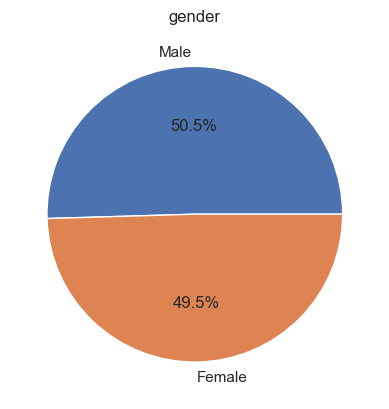

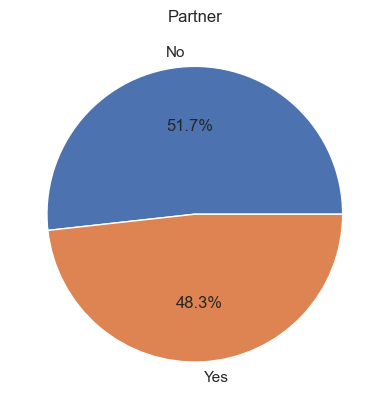

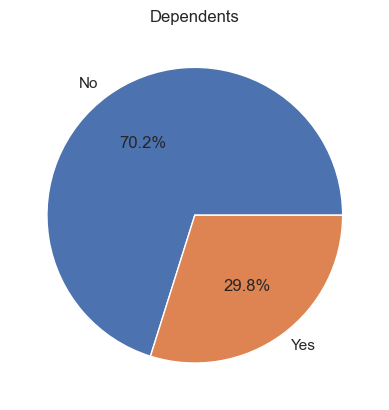

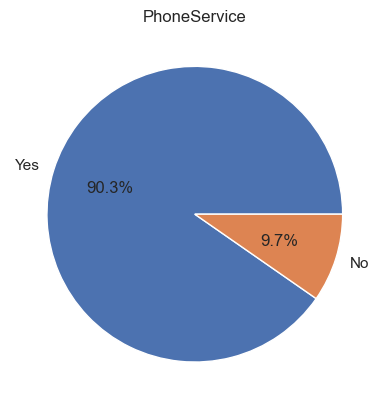

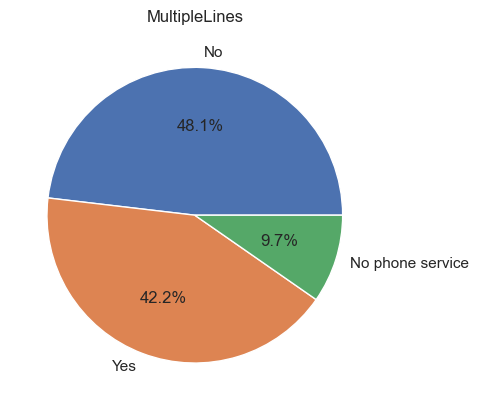

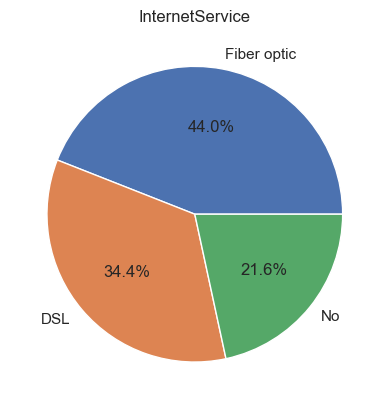

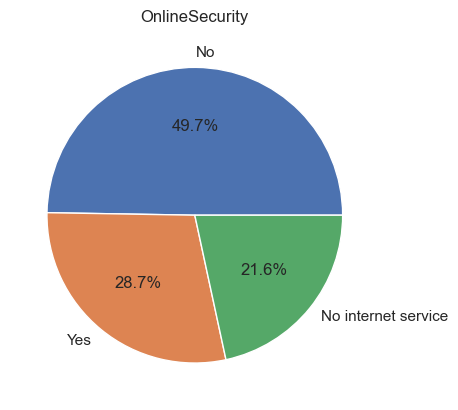

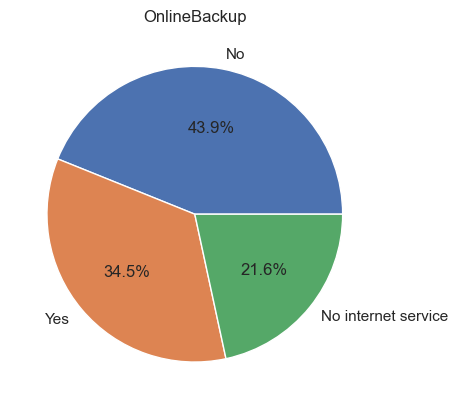

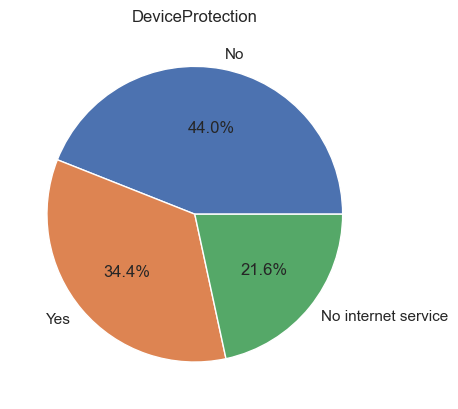

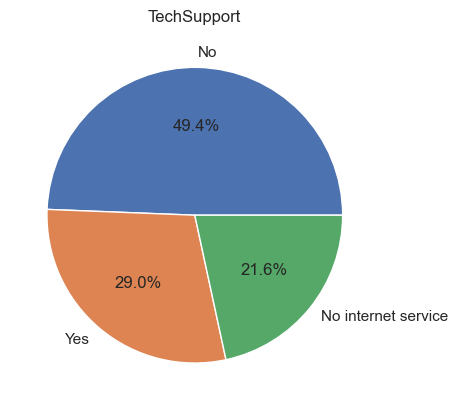

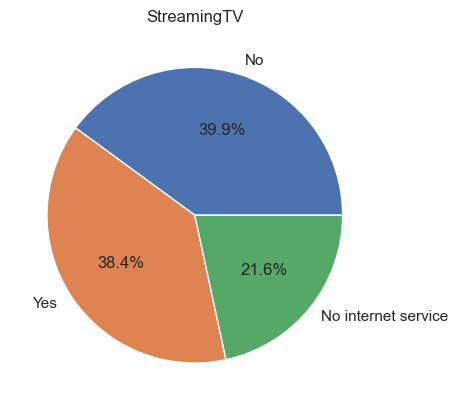

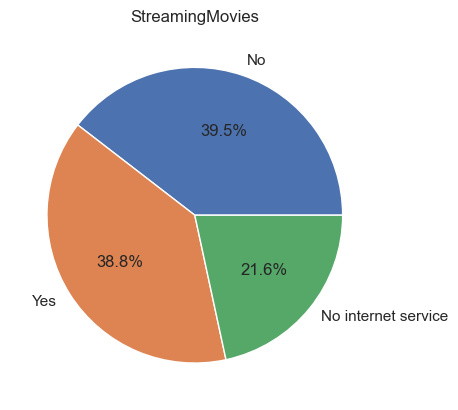

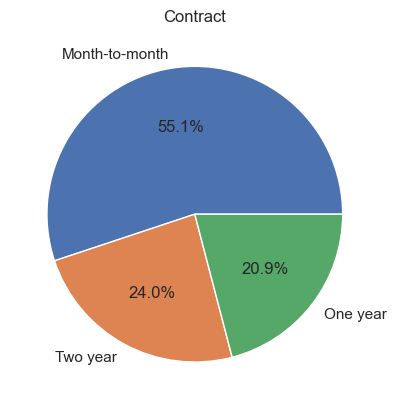

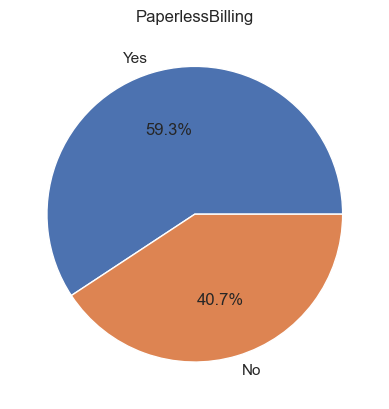

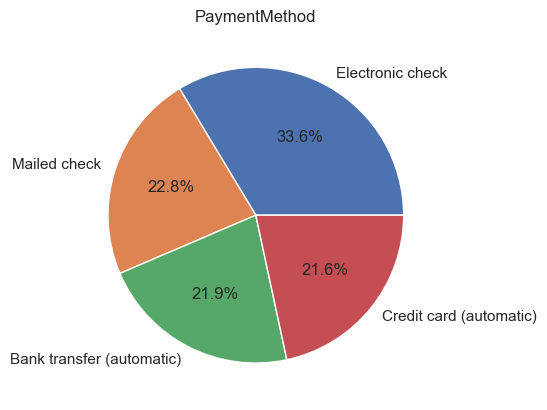

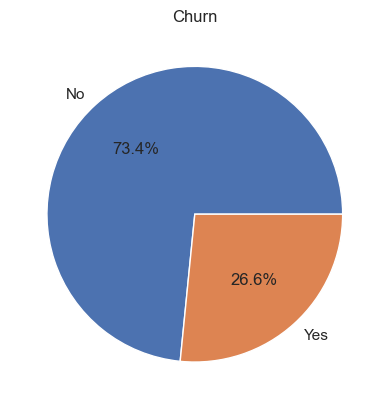

In [4]:
for col in df.select_dtypes('object').columns:
    plt.figure()
    plt.title('{}'.format(col))
    plt.pie(x = df[col].value_counts(), labels= df[col].value_counts().index, autopct='%1.1f%%')

<Axes: >

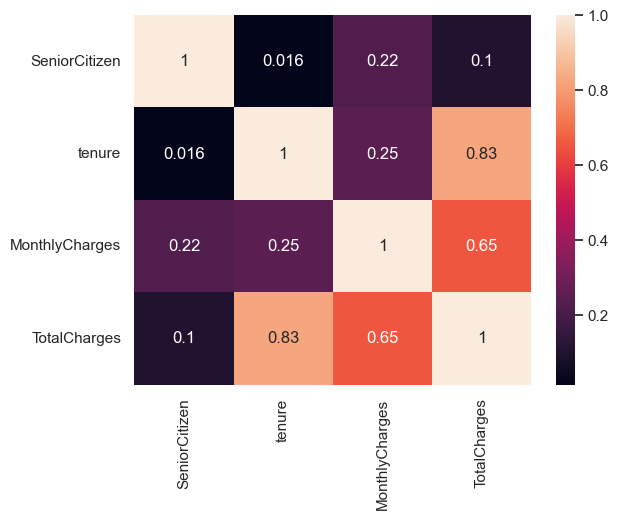

In [5]:
sns.heatmap(data = df.select_dtypes(['int','float']).corr(), annot = True)

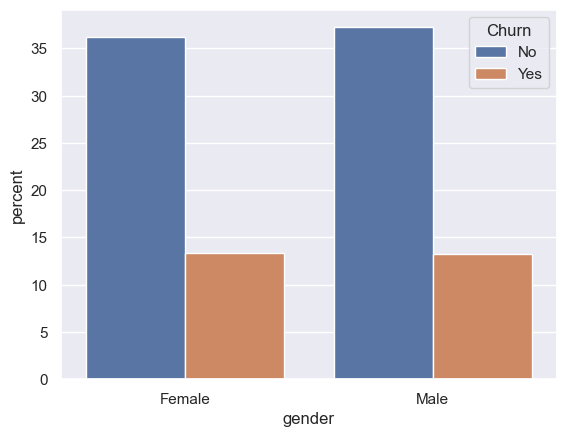

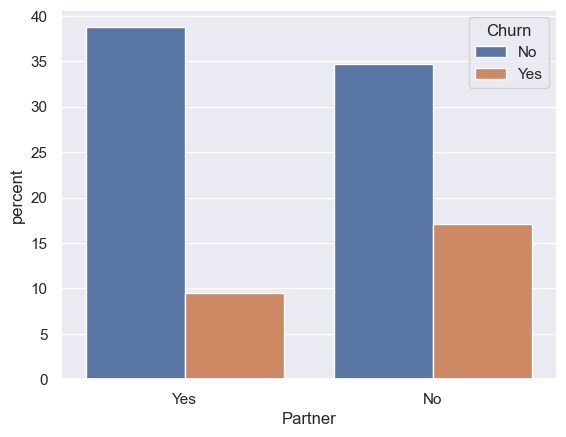

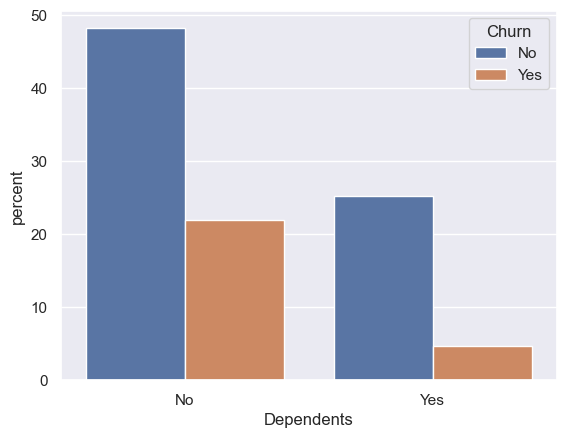

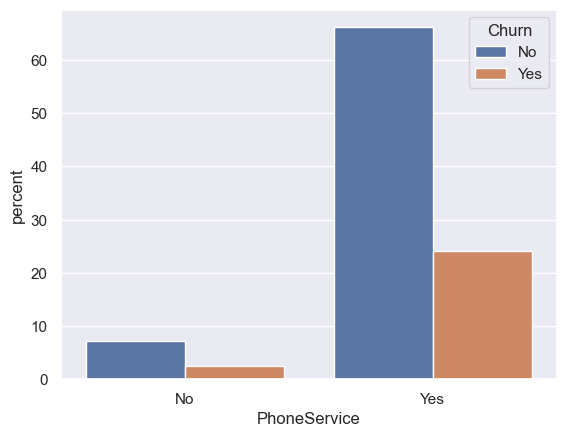

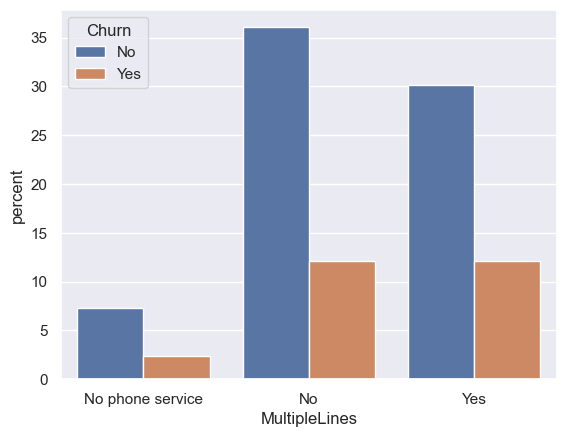

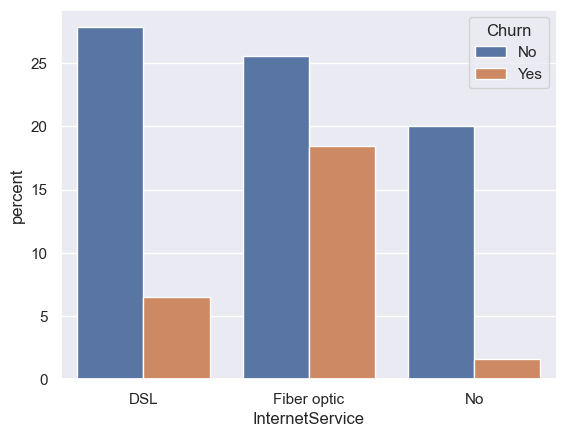

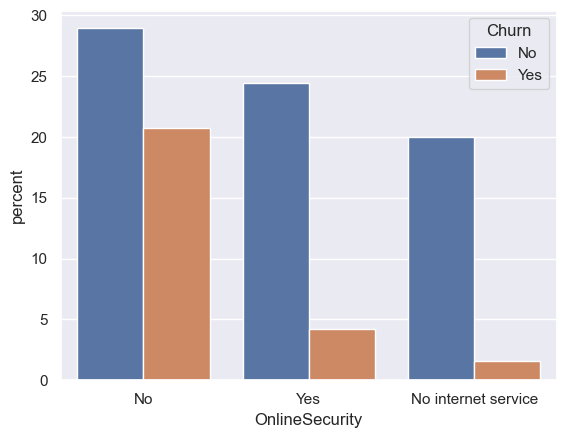

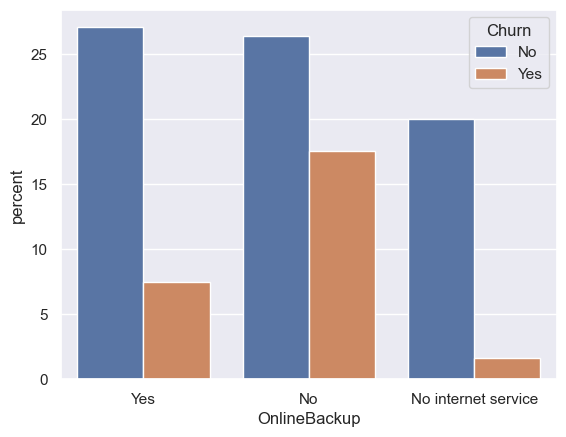

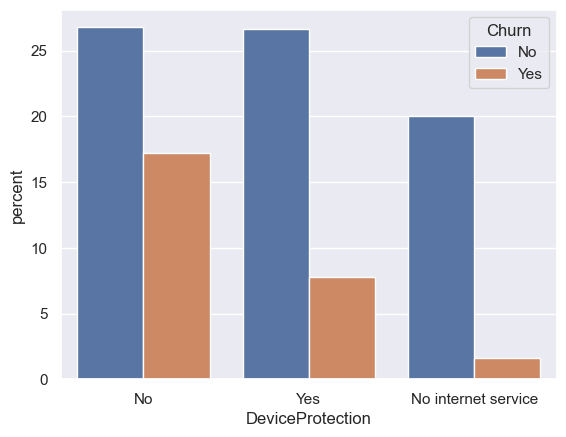

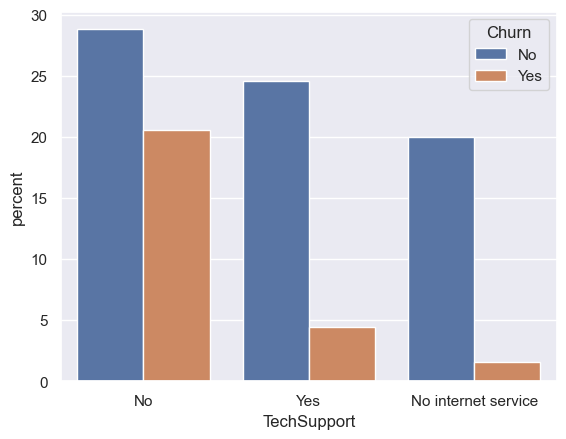

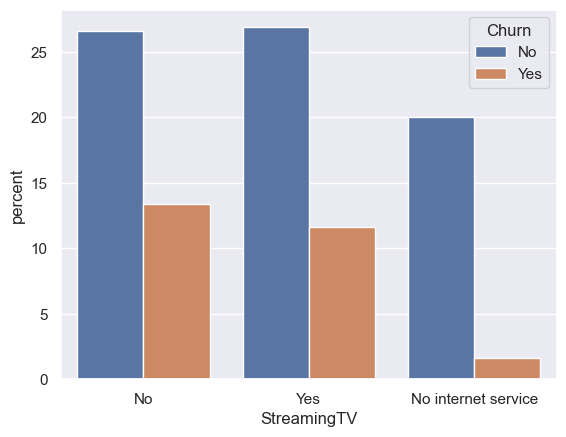

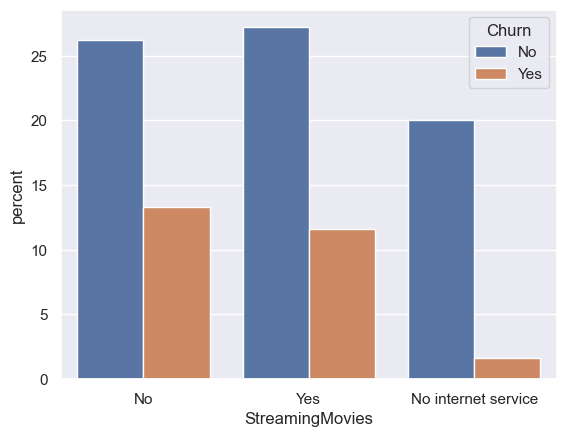

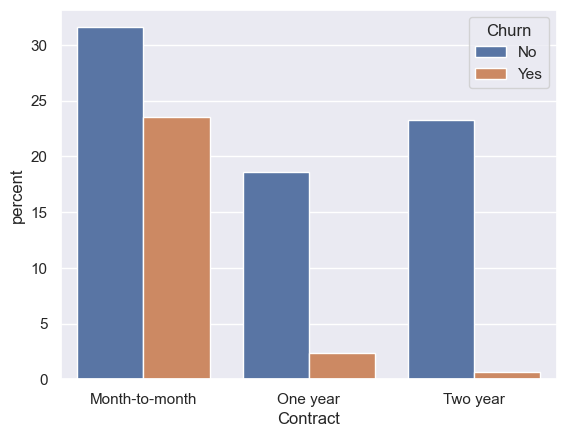

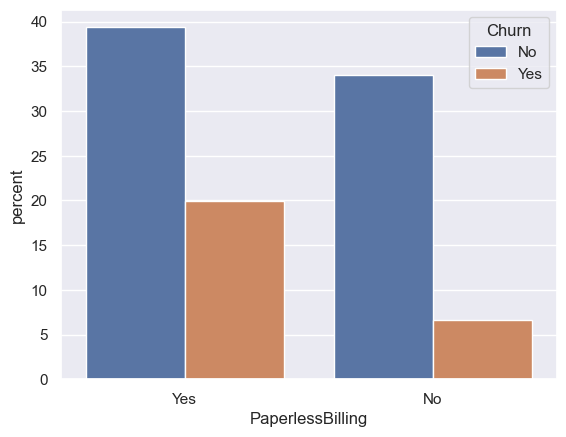

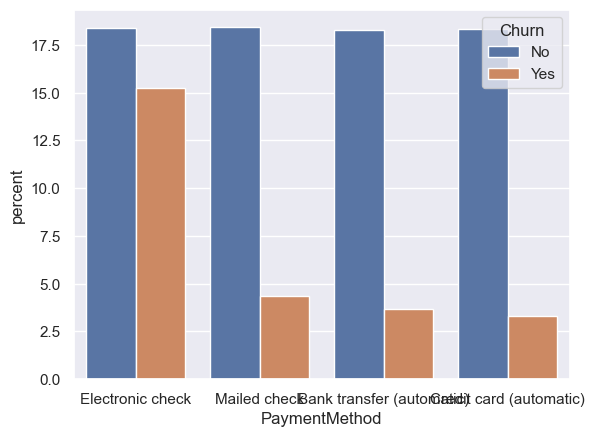

In [6]:
for col in df.select_dtypes('object').columns.drop(['Churn']):
    plt.figure()
    sns.countplot(data = df, x = col, hue = 'Churn', stat = 'percent');

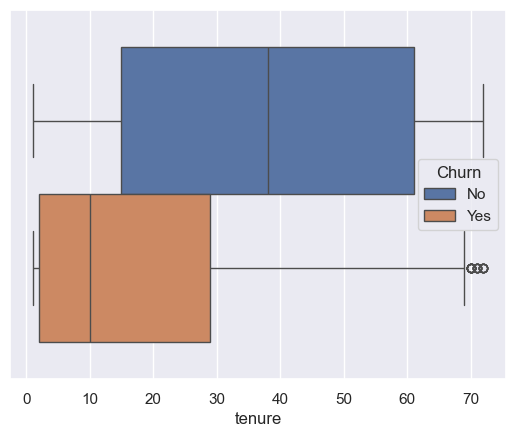

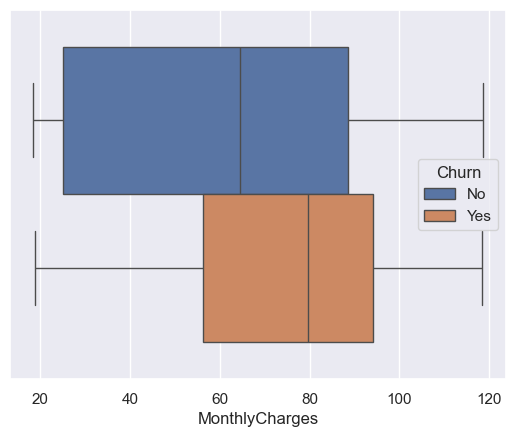

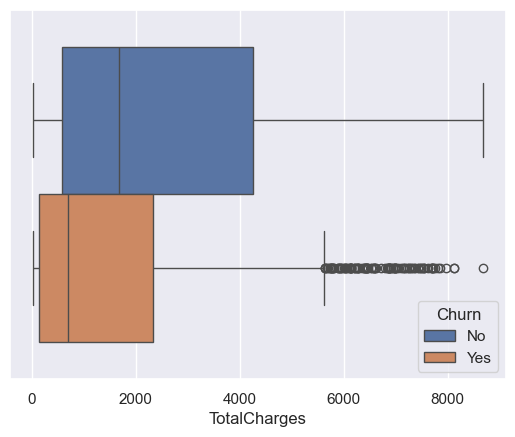

In [7]:
for col in df.select_dtypes(['int','float']).columns[1:]:
    plt.figure()
    sns.boxplot(data = df, x = col, hue = 'Churn')

### Préprocessing

In [8]:
# sélectionner les variables binaires Yes or No et les remplacer respectivement par 1 et 0
def selectionner_colonnes_binaires (df):
    colonnes_binaires = []
    for col in df.select_dtypes('object').columns:
        if set(df[col].unique()) == {"Yes","No"}:
            colonnes_binaires.append(col)
    return colonnes_binaires

df[selectionner_colonnes_binaires] = df[selectionner_colonnes_binaires(df)].replace({"Yes" : 1, "No" : 0})

C:\Users\antho\AppData\Local\Temp\ipykernel_5728\650343198.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[selectionner_colonnes_binaires] = df[selectionner_colonnes_binaires(df)].replace({"Yes" : 1, "No" : 0})


In [9]:
# remplacer female par 0 et male par 1
df['gender'] = df['gender'].replace({"Female" : 0, "Male" : 1})

# one hot encoding
df = pd.get_dummies(data = df)

# supprimer toutes les colonnes contenant no internet service sauf une car toutes identiques
df = df.drop([col for col in df.columns if "No internet service" in col][1:], axis = 1)

#Supprimer la colonne no_phone_service de multiplelines car info déjà dans la variable PhoneService
df.drop('MultipleLines_No phone service', axis = 1, inplace=True)

# Renommer la colonne "No_internet_service"
df = df.rename(columns={"OnlineSecurity_No internet service" : "No_internet_service"})

C:\Users\antho\AppData\Local\Temp\ipykernel_5728\726767050.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({"Female" : 0, "Male" : 1})


In [10]:
df.shape

(7032, 35)

### Modélisation

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import roc_curve,auc

In [12]:
# séparations du jeu de données en target et data
target = df.Churn
data = df.drop('Churn', axis = 1)

In [13]:
# jeu d'entraînement et jeu de test
x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.2,random_state=66)

# sous échantillonner
x_train_us,y_train_us = SMOTE(random_state=42).fit_resample(x_train,y_train)  # Added random_state for reproducibility

# sur échantilloner
x_train_os,y_train_os = RandomUnderSampler(random_state=42).fit_resample(x_train,y_train) # Added random_state for reproducibility

Optimisation des hyperparamètres pour : Logistic Regression
Meilleurs hyperparamètres pour Logistic Regression: {'model__solver': 'saga', 'model__C': 1, 'kbest__k': 30}
Meilleur score (validation croisée) pour Logistic Regression: 0.7606
| Réel   |   0 |   1 |   Total |
|:-------|----:|----:|--------:|
| 0      | 600 | 446 |    1046 |
| 1      |  25 | 336 |     361 |
| Total  | 625 | 782 |    1407 | 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.57      0.93      0.72      0.73      0.51      1046
          1       0.43      0.93      0.57      0.59      0.73      0.55       361

avg / total       0.82      0.67      0.84      0.68      0.73      0.52      1407



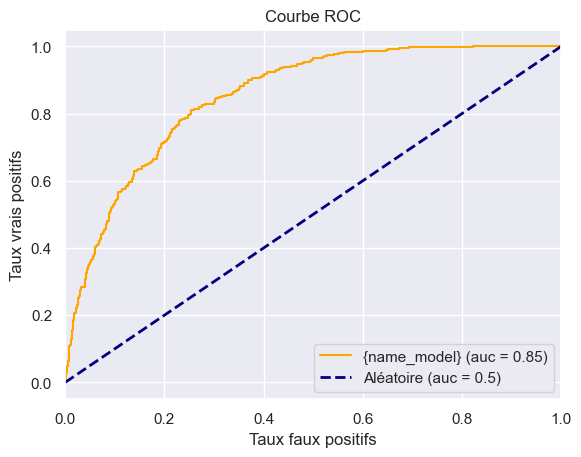

Optimisation des hyperparamètres pour : Support Vector Machine
Meilleurs hyperparamètres pour Support Vector Machine: {'model__kernel': 'linear', 'model__gamma': 0.001, 'model__C': 1, 'kbest__k': 10}
Meilleur score (validation croisée) pour Support Vector Machine: 0.7440
| Réel   |   0 |   1 |   Total |
|:-------|----:|----:|--------:|
| 0      | 696 | 350 |    1046 |
| 1      |  60 | 301 |     361 |
| Total  | 756 | 651 |    1407 | 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.67      0.83      0.77      0.74      0.55      1046
          1       0.46      0.83      0.67      0.59      0.74      0.56       361

avg / total       0.80      0.71      0.79      0.73      0.74      0.55      1407



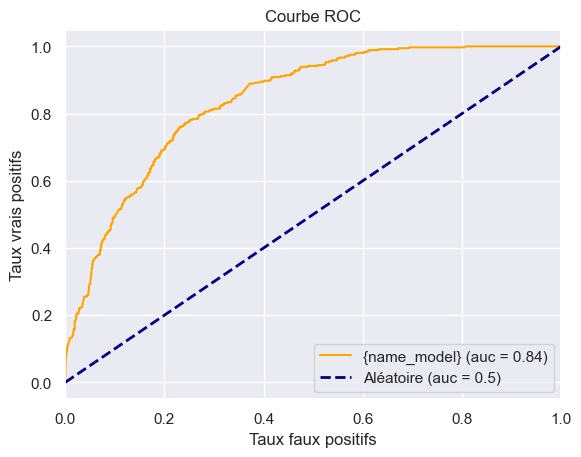

Optimisation des hyperparamètres pour : Random Forest
Meilleurs hyperparamètres pour Random Forest: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 3, 'model__max_depth': None, 'kbest__k': 20}
Meilleur score (validation croisée) pour Random Forest: 0.7586
| Réel   |   0 |   1 |   Total |
|:-------|----:|----:|--------:|
| 0      | 613 | 433 |    1046 |
| 1      |  27 | 334 |     361 |
| Total  | 640 | 767 |    1407 | 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.59      0.93      0.73      0.74      0.52      1046
          1       0.44      0.93      0.59      0.59      0.74      0.56       361

avg / total       0.82      0.67      0.84      0.69      0.74      0.53      1407



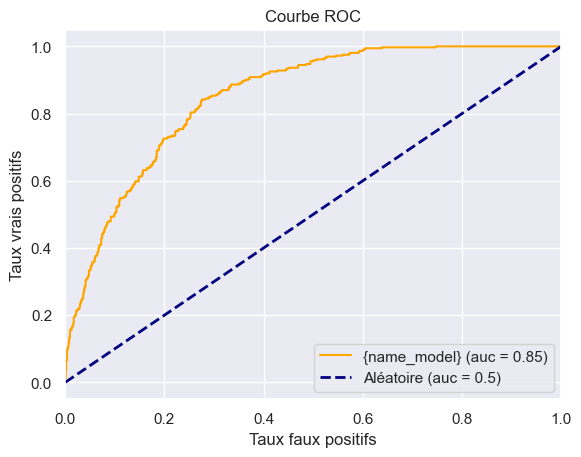

Optimisation des hyperparamètres pour : Decision Tree
Meilleurs hyperparamètres pour Decision Tree: {'model__min_samples_split': 2, 'model__min_samples_leaf': 3, 'model__max_depth': 5, 'model__criterion': 'gini', 'kbest__k': 10}
Meilleur score (validation croisée) pour Decision Tree: 0.7510
| Réel   |   0 |   1 |   Total |
|:-------|----:|----:|--------:|
| 0      | 555 | 491 |    1046 |
| 1      |  25 | 336 |     361 |
| Total  | 580 | 827 |    1407 | 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.53      0.93      0.68      0.70      0.47      1046
          1       0.41      0.93      0.53      0.57      0.70      0.51       361

avg / total       0.82      0.63      0.83      0.65      0.70      0.48      1407



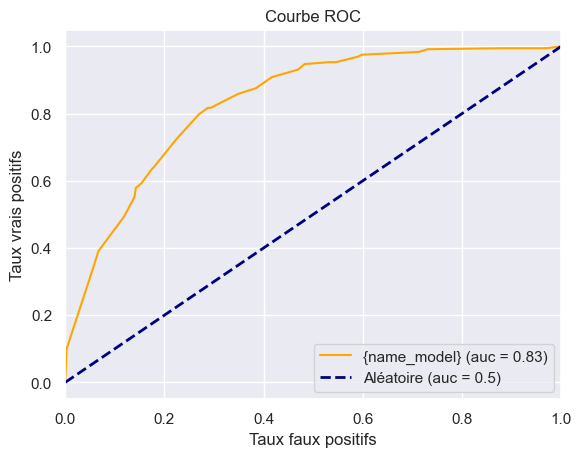


Résultats comparatifs :
Logistic Regression: Meilleur score = 0.7606, Meilleurs paramètres = {'model__solver': 'saga', 'model__C': 1, 'kbest__k': 30}
Support Vector Machine: Meilleur score = 0.7440, Meilleurs paramètres = {'model__kernel': 'linear', 'model__gamma': 0.001, 'model__C': 1, 'kbest__k': 10}
Random Forest: Meilleur score = 0.7586, Meilleurs paramètres = {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 3, 'model__max_depth': None, 'kbest__k': 20}
Decision Tree: Meilleur score = 0.7510, Meilleurs paramètres = {'model__min_samples_split': 2, 'model__min_samples_leaf': 3, 'model__max_depth': 5, 'model__criterion': 'gini', 'kbest__k': 10}


In [14]:
scaler = StandardScaler()
selector = SelectKBest()
clf_lr = LogisticRegression()
clf_svm = SVC(probability=True)
clf_rf = RandomForestClassifier()
clf_dt = DecisionTreeClassifier()


list_of_models = [('Logistic Regression', clf_lr),
                   ('Support Vector Machine', clf_svm),
                   ('Random Forest', clf_rf),
                   ('Decision Tree', clf_dt)]


results = {}

for name_model, model in list_of_models:
    print(f"Optimisation des hyperparamètres pour : {name_model}")
    model_pipeline = Pipeline(steps=[('normalisation', scaler),
                                        ('kbest', selector),
                                        ('model', model)])

    params = {}

    if name_model == 'Logistic Regression':
        params = {'kbest__k': [5, 10, 15, 20, 25, 30, 'all'],
                    'model__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
                    'model__C': [0.001, 0.01, 0.1, 1]}
    elif name_model == 'Support Vector Machine':
        params = {'kbest__k': [5, 10, 15, 20, 25, 30, 'all'],
                    'model__C': [0.1, 1, 10],
                    'model__gamma': ['scale', 'auto', 0.001, 0.1],
                    'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
    elif name_model == 'Random Forest':
        params = {'kbest__k': [5, 10, 15, 20, 25, 30, 'all'],
                    'model__n_estimators': [100, 200, 300],
                    'model__max_depth': [None, 5, 10],
                    'model__min_samples_split': [2, 5],
                    'model__min_samples_leaf': [1, 3]}
    elif name_model == 'Decision Tree':
        params = {'kbest__k': [5, 10, 15, 20, 25, 30, 'all'],
                    'model__criterion': ['gini', 'entropy'],
                    'model__max_depth': [None, 5, 10],
                    'model__min_samples_split': [2, 5],
                    'model__min_samples_leaf': [1, 3]}


    grid = RandomizedSearchCV(model_pipeline, params, cv=5, scoring='accuracy', n_jobs=-1, random_state=42) # Added random_state for reproducibility
    grid.fit(x_train_os, y_train_os)
    y_pred = grid.predict(x_test)
    y_pred_proba = grid.predict_proba(x_test)
    y_preds = np.where(y_pred_proba[:,1]>0.35, 1, 0)

    print(f"Meilleurs hyperparamètres pour {name_model}: {grid.best_params_}")
    print(f"Meilleur score (validation croisée) pour {name_model}: {grid.best_score_:.4f}")
    results[f"{name_model}"] = {'best_score': grid.best_score_, 'best_params': grid.best_params_, 'best_model': grid.best_estimator_}
    print(pd.crosstab(y_test, y_preds, rownames=['Réel'], colnames=['Prédit'], margins=True, margins_name='Total').to_markdown(), '\n')
    print(classification_report_imbalanced(y_test,y_preds))

    
    fpr,tpr,seuils = roc_curve(y_test,y_pred_proba[:,1],pos_label = 1)
    roc_auc = auc(fpr,tpr)

    plt.plot(fpr,tpr, c = 'orange', label = '{name_model} (auc = %0.2f)'% roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.xlabel('Taux faux positifs')
    plt.ylabel('Taux vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc = 'lower right');
    plt.show();



print("\nRésultats comparatifs :")
for name, result in results.items():
    print(f"{name}: Meilleur score = {result['best_score']:.4f}, Meilleurs paramètres = {result['best_params']}")

L'objectif ici est d'avoir un recall de la classe 1 important tout en ne pénalisant pas la classe 0. Penser également à regarder la moyenne géométrique.
Modifier les seuils de probabilités qui ressortent des modèles. On a tracé les corbes de ROC des différents modèles. Après analyse des tableaux de classification report imbalanced, il semblerait que ce soit le modèle de regression logistique ou un random forest classifier qui sont les plus performants.

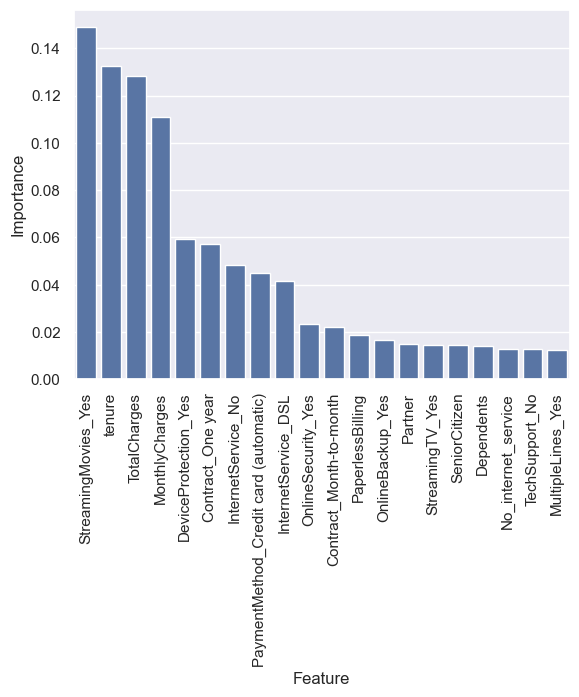

In [34]:
selector = SelectKBest(k = 25)
clf_rf = RandomForestClassifier(n_estimators= 200, min_samples_split=5,min_samples_leaf = 1, max_depth = 10, random_state= 66)
rf_pipeline = Pipeline(steps=[('normalisation', scaler),
                              ('kbest', selector),
                              ('model', clf_rf)])

rf_pipeline.fit(x_train_os,y_train_os)
y_pred = rf_pipeline.predict(x_test)

trained_model = rf_pipeline.named_steps['model']
feature_importances = trained_model.feature_importances_

selected_features_indices = rf_pipeline.named_steps['kbest'].get_support(indices = True)
selected_features_names = [f'{i}' for i in df.columns[selected_features_indices]]

feature_importances_df = pd.DataFrame({'Feature' : selected_features_names,'Importance' : feature_importances}).sort_values(by = 'Importance', ascending=False)

sns.barplot(data = feature_importances_df[:20], x = 'Feature', y = 'Importance')
plt.xticks(rotation = 90);


### Feature_importances
- Les variables les plus importances dans le choix que réalise le modèle sur la classification binaire semblent être streamingmovies_yes (le client a l'option film en streaming), tenure (nb de mois que le  client est abonné), totalcharges et monthly charges (les charges mensuelles et depuis le début de l'abonnement). Ces 4 variables représentent plus de 50% de l'explication du choix du modèle dans la classification churner. Les autres variables ont un impact plus faible (- de 6%)

In [24]:
feature_importances_df

,Feature,Importance
19,StreamingMovies_Yes,0.149486
3,tenure,0.133059
6,TotalCharges,0.125760
5,MonthlyCharges,0.112020
15,DeviceProtection_Yes,0.063974
21,Contract_One year,0.060548
10,InternetService_No,0.051174
8,InternetService_DSL,0.040571
24,PaymentMethod_Credit card (automatic),0.036798
13,OnlineSecurity_Yes,0.025118
